# Teleconnection plot

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import intake
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')

# choose where to load data from:
load_data_from = 'cloud'
#load_data_from = 'glade'

if load_data_from == 'glade':
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

# models with future scenarios:
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']

file = '../Processed_data/number_of_control_stds.txt'
stds = pd.read_csv(file, index_col=0, header=[0,1])
exps = stds[models[0]].columns.values

file2 = '../Processed_data/picontrol_std_ratio.txt'
control_stds = pd.read_csv(file2, index_col=0)


#### cloud lacks dataset for ssp370 psl for several models

MCM-UA-1-0 historical+ssp245


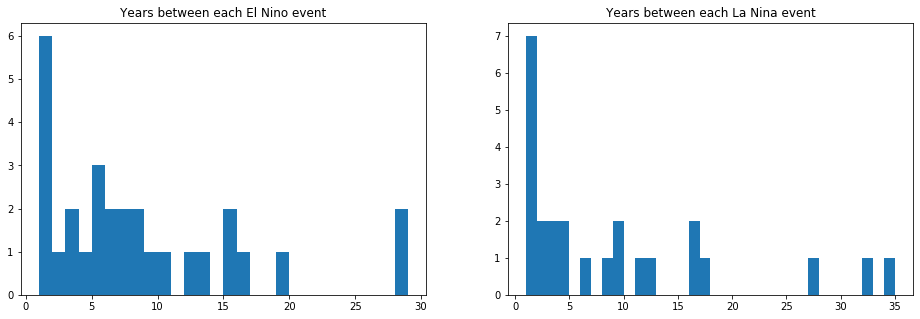

In [112]:
# choose model and experiement for histogram:
model = models[10]
exp = exps[1]
print(model, exp)

nstd = stds[model][exp]
years = nstd.index

# find out when nstd is < -1 or > +1
elnino_ind = np.where(nstd > 1); elnino_years = years[elnino_ind]
lanina_ind = np.where(nstd < -1); lanina_years = years[lanina_ind]
data1 = np.diff(elnino_years); binwidth = 1
data2 = np.diff(lanina_years);

fig, ax = plt.subplots(ncols = 2, figsize = [16,5])
ax[0].hist(data1, bins=range(min(data1), max(data1) + binwidth, binwidth))
ax[1].hist(data2, bins=range(min(data2), max(data2) + binwidth, binwidth))

ax[0].set_title('Years between each El Nino event')
ax[1].set_title('Years between each La Nina event');

## Define functions

In [113]:
def area_weights(lat_bnds, lon_bnds): 
    # computes exact area weigths assuming earth is a perfect sphere
    lowerlats = np.radians(lat_bnds[:,0]); upperlats = np.radians(lat_bnds[:,1])
    difflon = np.radians(np.diff(lon_bnds[0,:])) # if the differences in longitudes are all the same
    areaweights = difflon*(np.sin(upperlats) - np.sin(lowerlats));
    areaweights /= areaweights.mean()
    return areaweights # list of weights, of same dimension as latitude

# function copied from: http://xarray.pydata.org/en/stable/examples/monthly-means.html
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

# function copied from: http://xarray.pydata.org/en/stable/examples/monthly-means.html
def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar) and month == 2: # the feb-test is missing at the website!
            month_length[i] += 1
    return month_length

# inspiration taken from: http://xarray.pydata.org/en/stable/examples/monthly-means.html

# days per month:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
      }

def day_weights(ds, chosen_season = 'DJF', calendar = 'noleap'): # new function
    month_length = xr.DataArray(get_dpm((ds.time.to_index()), calendar=ds_calendar), coords=[ds.time], name='month_length')
    if chosen_season == 'DJF':
        season_months = month_length.where(month_length['time.season'] == chosen_season)
        # repeat last December month, and move it to the beginning
        season_months = xr.concat([season_months[-1], season_months], dim = 'time')

        norm_by_annual = season_months[1:].groupby('time.year').mean('time') # make annual mean
        norm_by_monthly = np.concatenate([np.tile(norm_by_annual.values[i], 12) for i in range(len(norm_by_annual.values))])
        # repeat last December month to give it equal length as season_months. Value of last month will not be used.
        norm_by_monthly = np.concatenate([norm_by_monthly, [norm_by_monthly[-1]]])

        weights = season_months/norm_by_monthly
        # make weigths have mean 1 in chosen season for all years
        # can be checked by running weights.rolling(min_periods=3, center=True, time=3).mean()
        # note that these weights start with a December month
    elif chosen_season == 'all':
        
        ##### This code is not tested yet #####
        norm_by_annual = month_length.groupby('time.year').mean('time') # make annual mean
        norm_by_monthly = np.concatenate([np.tile(norm_by_annual.values[i], 12) for i in range(len(norm_by_annual.values))])
        weights = month_length/norm_by_monthly
        # normalized to have mean 1
    # if other season wanted, continue developing this if-test
    
    # NB: normalised weights do not care what numbers are produced for other seasons
    return weights 


def sel_member(model): # finds members chosen for historical and ssp experiments
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0', 'CESM2', 'CESM2-WACCM']:
        chosen_member = 'r1i1p1f1'
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        chosen_member = 'r1i1p1f2'
    elif model in ['CNRM-ESM2-1']:
        chosen_member = 'r2i1p1f2'
    return chosen_member

def picontrol_member(model): # finds members chosen for piControl
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0', 'MCM-UA-1-0', 'CESM2', 'CESM2-WACCM']:
        chosen_member = 'r1i1p1f1'
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1', 'UKESM1-0-LL', 'CNRM-ESM2-1']:
        chosen_member = 'r1i1p1f2'
    return chosen_member

if model in ['BCC-CSM2-MR', 'FGOALS-g3', 'CanESM5', 'E3SM-1-0', 'GISS-E2-1-G', 'GISS-E2-1-H', 'CESM2', 'CESM2-WACCM', 'GFDL-CM4', 'SAM0-UNICON', 'GFDL-ESM4', 'MCM-UA-1-0']:
    ds_calendar = 'noleap'
elif model in ['CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6']:
    ds_calendar = 'gregorian'
elif model in ['EC-Earth3', 'EC-Earth3-Veg', 'MRI-ESM2-0']:
    ds_calendar = 'proleptic_gregorian'
elif model in ['UKESM1-0-LL', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM']:
    ds_calendar = '360_day'
    
print(ds_calendar, 'calendar')

noleap calendar


## load sea-level pressure for model

In [114]:
exp_list = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
exp_keys = {}; datasets = {}
for exp in exp_list:
    print(exp)
    if exp == 'piControl':
        member = picontrol_member(model)
    else:
        member = sel_member(model)
    cat = col.search(experiment_id = exp, source_id = model, variable_id='psl', table_id='Amon', member_id = member)
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
    for key in dset_dict.keys():
        exp_keys[exp] = key
        datasets[key] = dset_dict[key]
#exp_keys

piControl
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
historical
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp126
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp245
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp370
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 0 group(s)
ssp585
--> The keys in the returned di

In [117]:
if model == 'MCM-UA-1-0':
    exp_list = ['piControl', 'historical', 'ssp245', 'ssp370', 'ssp585']

for exp in exp_list:
    if exp in exp_keys:
        print(exp)
        if exp == 'piControl':
            member = picontrol_member(model)
        else:
            member = sel_member(model)

        key = exp_keys[exp]
        ds = datasets[key].sel(member_id = member)

        # time series of weights for DJF months, and nan otherwise
        weights = day_weights(ds, chosen_season = 'DJF', calendar = ds_calendar)

        if exp == 'piControl':
            dayw_avg = ds.psl*weights[1:]
            std_ratios = control_stds[model]
            years = ds.time.groupby('time.year').mean('time').year
        elif exp == 'historical':
            # save last december month for use in first year of ssp scenarios
            lastD = ds.isel(time = -1)
            continue # do not bother with computing anything for historical
        else: 
            ds_withlastD = xr.concat([lastD, ds], dim = 'time')  
            weights = weights.assign_coords(time = ds_withlastD.time)
            dayw_avg = ds.psl*weights

            std_ratios = stds[model]['historical+' + exp][164:];
            years = std_ratios.index
        elnino_ind = np.where(std_ratios > 1); elnino_years = years[elnino_ind]; 
        lanina_ind = np.where(std_ratios < -1); lanina_years = years[lanina_ind]; 
        # has values only in years up to 2100
        print('check1') # the next line is the most time-consuming step:
        dayw_avg3 = dayw_avg.rolling(min_periods=3, center=True, time=3).mean()
        print('check2')
        # mean found in line above, so the next line is just to get rid of all nan values
        DJFmean = dayw_avg3.groupby('time.year').mean('time') 

        elninomean = DJFmean.sel(year=elnino_years).mean('year')
        laninamean = DJFmean.sel(year=lanina_years).mean('year')
        elnino_dataset = elninomean.to_dataset(name = exp + '_elninomean')
        lanina_dataset = laninamean.to_dataset(name = exp + '_laninamean')
        if exp == 'piControl':
            xarr_collection = xr.merge([elnino_dataset, lanina_dataset])
        else:
            xarr_collection = xr.merge([xarr_collection, elnino_dataset, lanina_dataset], compat='override')



piControl
check1
check2
historical
ssp245
check1
check2
ssp585
check1
check2


In [118]:
xarr_collection

<xarray.Dataset>
Dimensions:               (latitude: 80, longitude: 96)
Coordinates:
  * latitude              (latitude) float64 -88.29 -86.07 ... 86.07 88.29
  * longitude             (longitude) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
    member_id             <U8 'r1i1p1f1'
Data variables:
    piControl_elninomean  (latitude, longitude) float64 dask.array<chunksize=(80, 96), meta=np.ndarray>
    piControl_laninamean  (latitude, longitude) float64 dask.array<chunksize=(80, 96), meta=np.ndarray>
    ssp245_elninomean     (latitude, longitude) float64 dask.array<chunksize=(80, 96), meta=np.ndarray>
    ssp245_laninamean     (latitude, longitude) float64 dask.array<chunksize=(80, 96), meta=np.ndarray>
    ssp585_elninomean     (latitude, longitude) float64 dask.array<chunksize=(80, 96), meta=np.ndarray>
    ssp585_laninamean     (latitude, longitude) float64 dask.array<chunksize=(80, 96), meta=np.ndarray>

In [107]:
#xarr_collection.ssp585_elninomean.plot()
#xarr_collection.ssp585_laninamean.plot()

In [119]:
xarr_collection.to_netcdf('../Processed_data/mean_psl/' + model +'_ensomean_psl.nc')

## Load netcdf files created above, and plot results:

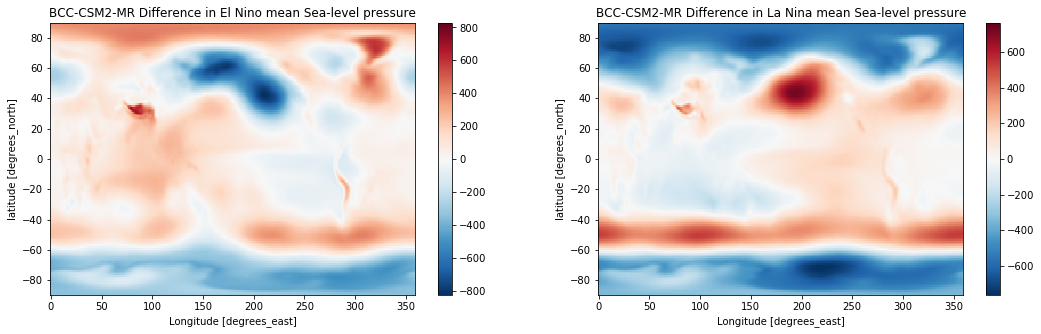

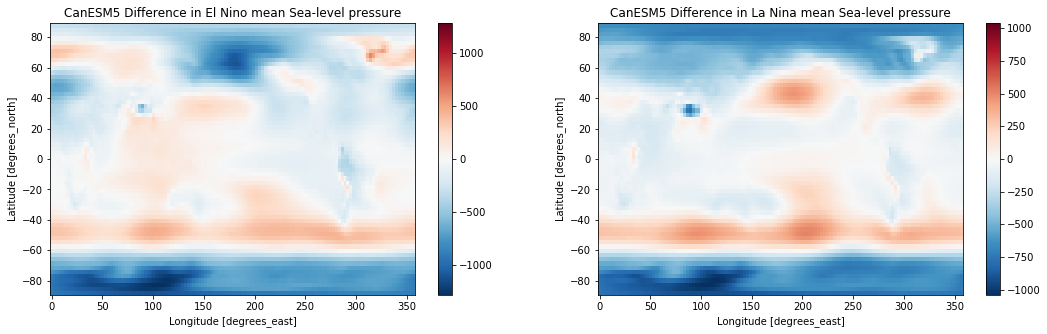

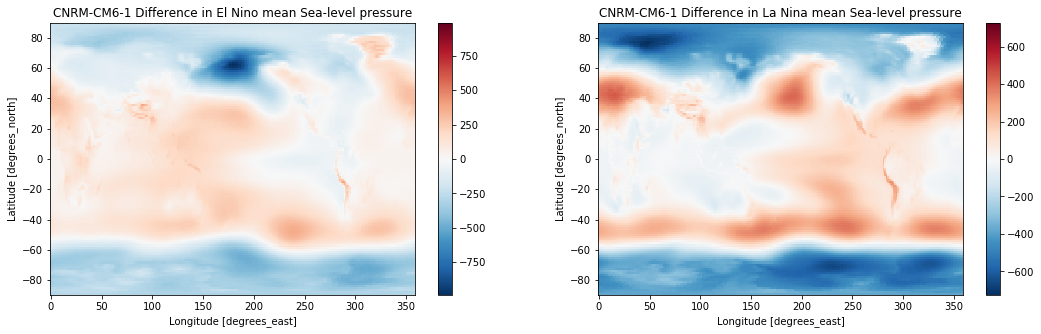

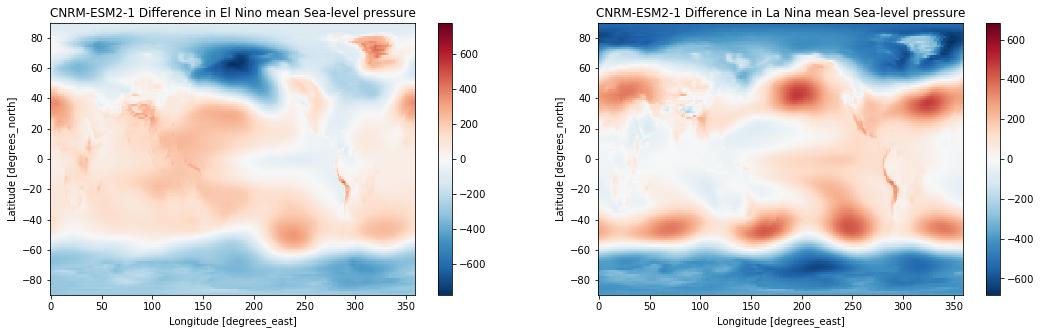

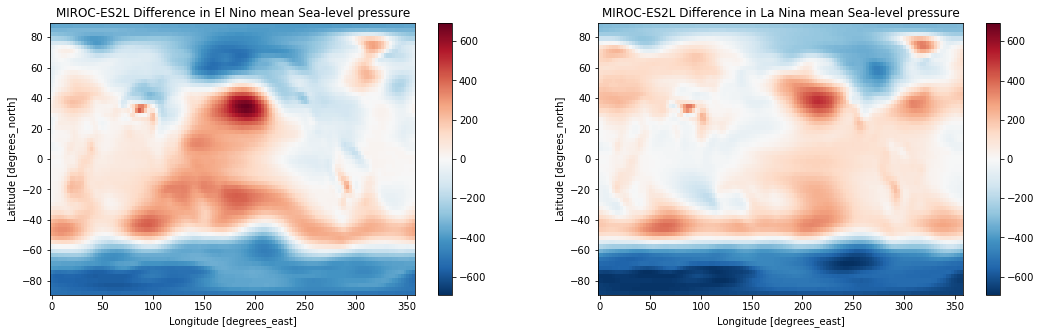

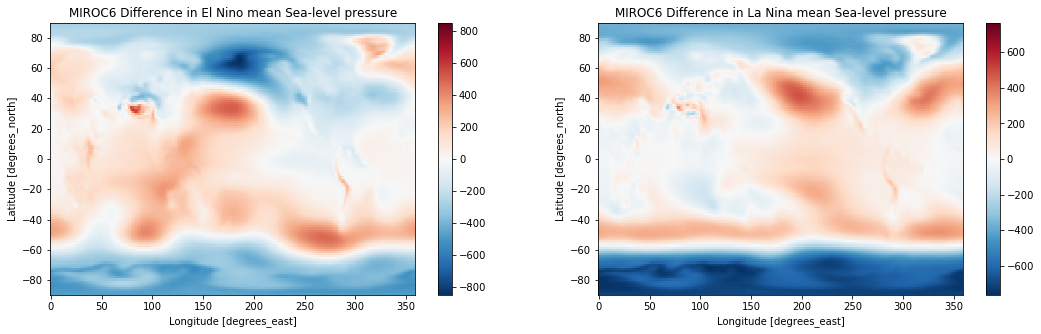

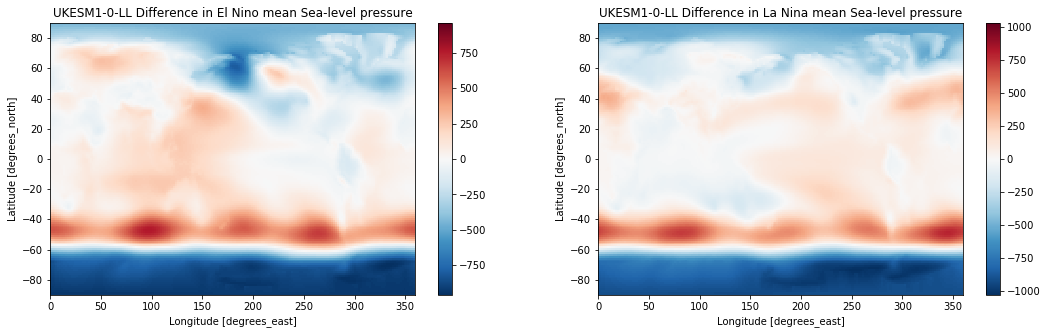

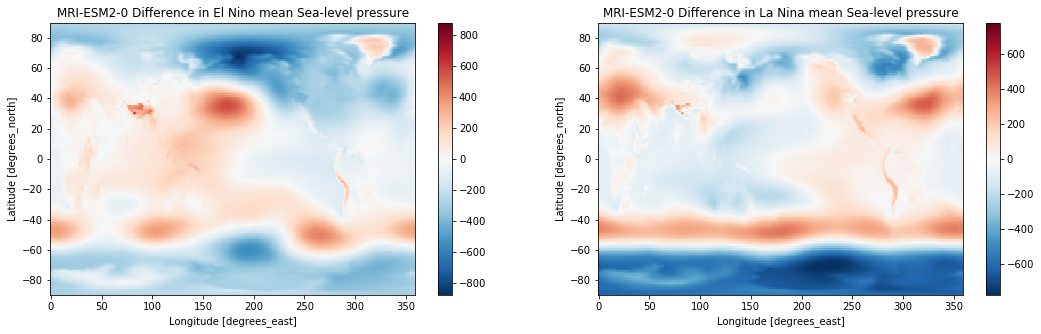

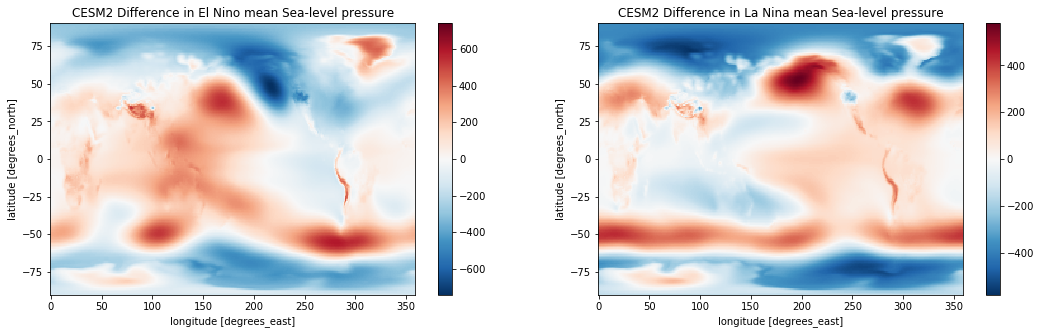

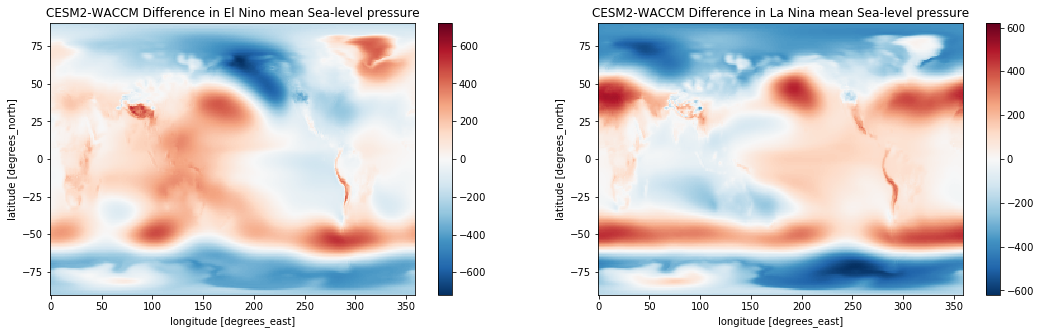

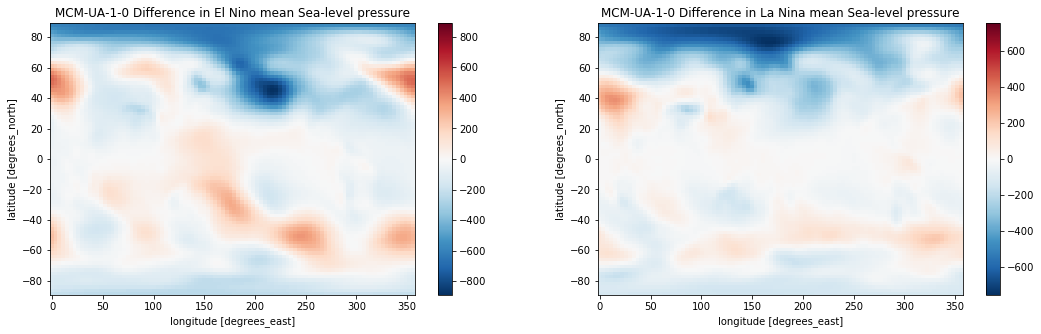

In [174]:
nino_diffs = {}; nina_diffs = {}; 

for model in models:
    data = xr.open_dataset('../Processed_data/mean_psl/' + model +'_ensomean_psl.nc')
    exp = 'ssp585'
    fig, ax = plt.subplots(ncols = 2, figsize = [18,5])
    nino_diffs[model] = data[exp + '_elninomean'] - data['piControl_elninomean']
    nina_diffs[model] = data[exp + '_laninamean'] - data['piControl_laninamean']
    (nino_diffs[model]).plot(ax = ax[0])
    (nina_diffs[model]).plot(ax = ax[1])
    ax[0].set_title(model + ' Difference in El Nino mean Sea-level pressure')
    ax[1].set_title(model + ' Difference in La Nina mean Sea-level pressure')



## Regrid before averaging, so that all models get the same grid:

Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_80x96_180x360_peri.nc


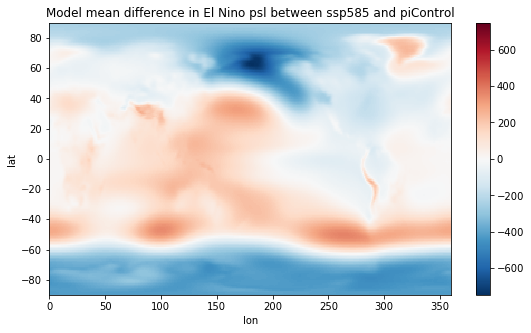

In [171]:
import xesmf as xe

res = 1;
ds_out = xr.Dataset({'lon': (['lon'], np.arange(res/2, 360+res/2, res)),
                     'lat': (['lat'], np.arange(-90+res/2, 90+res/2, res))
                    })

for model in models:
    nino_diff = nino_diffs[model]
    if model == 'MCM-UA-1-0':
        nino_diff = nino_diff.rename({'longitude': 'lon','latitude': 'lat'})
    regridder = xe.Regridder(nino_diff, ds_out, 'bilinear', reuse_weights = True, periodic = True)
    regridded_data = regridder(nino_diff)
    if model == models[0]:
        datasum = regridded_data
    else: 
        datasum += regridded_data
ninomean = datasum/len(models)
fig, ax = plt.subplots(figsize = [9,5])
ninomean.plot(ax = ax)
ax.set_title('Model mean difference in El Nino psl between ssp585 and piControl');


Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_80x96_180x360_peri.nc


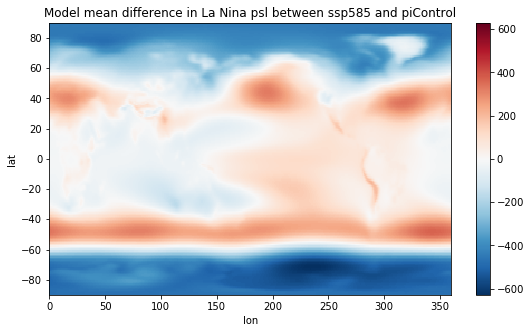

In [170]:
for model in models:
    nina_diff = nina_diffs[model]
    if model == 'MCM-UA-1-0':
        nina_diff = nina_diff.rename({'longitude': 'lon','latitude': 'lat'})
    regridder = xe.Regridder(nina_diff, ds_out, 'bilinear', reuse_weights = True, periodic = True)
    regridded_data = regridder(nina_diff)
    if model == models[0]:
        datasum = regridded_data
    else: 
        datasum += regridded_data
ninamean = datasum/len(models)

fig, ax = plt.subplots(figsize = [9,5])
ninamean.plot(ax = ax)
ax.set_title('Model mean difference in La Nina psl between ssp585 and piControl');
